###Ilgın Şara Hacipoğlu- 25448

In [1]:
!pip install reverse_geocoder

In [2]:
!pip install geopy

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import reverse_geocoder as rg
from geopy import distance
from geopy.distance import geodesic
sns.set(style="darkgrid")

%matplotlib inline

from os.path import join
from pprint import pprint


In [4]:
d_file= "taxi-trips.csv"

In [5]:
dataf= pd.read_csv("taxi-trips.csv")

In [6]:
dataf.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225
2,id3361153,1,2016-03-11 07:11:23,2016-03-11 07:20:09,1,-73.994560,40.750526,-73.978500,40.756191,N,526
3,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346
4,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695


In [7]:
dataf.shape

(118185, 11)

Number or rows is 118185.

Number of colums is 11.

In [8]:
dataf.ndim

2

In [9]:
print(dataf.columns)


Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')


In [10]:
dataf.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

**Checking for NaN values**


Before starting to work on data, it is useful to check for and eliminate rows or various columns if neccessary.

In [11]:
dataf.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Converting "pickup_datetime" and "dropoff_datetime" columns from object to datetime type. 

In [12]:
dataf["pickup_datetime"]= pd.to_datetime(dataf["pickup_datetime"], format = "%Y-%m-%d %H:%M:%S")

In [13]:
dataf["pickup_datetime"].dtype

dtype('<M8[ns]')

In [14]:
dataf["dropoff_datetime"]= pd.to_datetime(dataf["dropoff_datetime"], format = "%Y-%m-%d %H:%M:%S")

In [15]:
dataf["dropoff_datetime"].dtype

dtype('<M8[ns]')

**Descriptive Stats about Data**

Taking a brief look at the head of the dataset one can suspect if all the values in store_and_fwd_flag column are "N". Below we see that there are also "Y" values which are relatively low in amount when compared to "N" values. 


In [16]:
dataf.store_and_fwd_flag.value_counts()

N    117634
Y       551
Name: store_and_fwd_flag, dtype: int64

In [17]:
dataf.passenger_count.value_counts()

1    84290
2    16800
5     6296
3     4634
6     3971
4     2188
0        6
Name: passenger_count, dtype: int64

According to value counts above, there are 6 occurences where passenger count was '0', which can be treated as an outlier. Thus, it would make sense eliminating rows in the dataframe that have value '0'in passenger_count column.

In [18]:

dataf = dataf[dataf.passenger_count > 0]

(array([84290., 16800.,  4634.,  2188.,  6296.,  3971.]),
 array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
        5.16666667, 6.        ]),
 <a list of 6 Patch objects>)

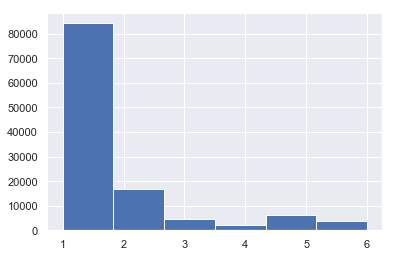

In [19]:
plt.hist(dataf["passenger_count"],bins= 6, label = "Passenger Count")

It can be observed that most of the rows in the dataframe contain 1 as passenger size. 

In [20]:
dataf.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,118179.000000,118179.000000,118179.000000,118179.000000,118179.000000,118179.000000,118179.000000
mean,1.534968,1.657232,-73.973972,40.751394,-73.973537,40.752214,927.214378
std,0.498778,1.313824,0.040453,0.027955,0.039184,0.032281,3118.781553
min,1.000000,1.000000,-79.487900,40.225803,-79.487900,40.225800,1.000000
25%,1.000000,1.000000,-73.991875,40.737837,-73.991394,40.736462,393.000000
50%,2.000000,1.000000,-73.981796,40.754501,-73.979759,40.754848,652.000000
75%,2.000000,2.000000,-73.967579,40.768473,-73.962990,40.770077,1048.000000
max,2.000000,6.000000,-73.425018,41.292198,-73.055977,41.292198,86366.000000


Here we see that some descriptive statistics about data does not make much sense such as the vendor_id. However, mean, standard deviation, min and max values of passenger_count, trip_duration gives us a general idea about the data.

Taking a brief look into trip_duration column, one would notice the substantial difference in time of the max value and the 75% of all the columns. Based on this, at least 75% of the data in that column would correspond to a lower amount than 1050. This suggests that it could be a significant case of outliers. 


Checking the boxplot of the trip_duration column could give information on how spread the data is. 


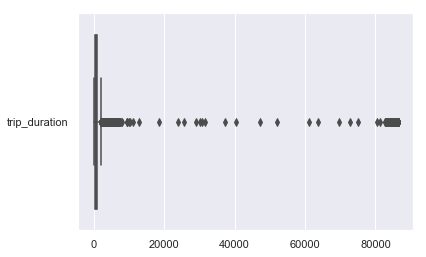

In [21]:
sns.boxplot(data=dataf[["trip_duration"]], orient="h")

This plot suggests that the max value of trip duration that is not an outlier lies below 3000-4000 seconds bound, and the rest is very scattered and can be considered candidates for outliers. Thus, elimination of such candidates could be beneficial. 

In [22]:
dataf[dataf.trip_duration > 3000]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
385,id1515308,1,2016-03-01 06:14:14,2016-03-01 07:07:41,2,-73.776741,40.645412,-73.987129,40.761059,N,3207
420,id1354279,2,2016-03-09 17:25:27,2016-03-09 18:19:31,4,-73.781845,40.644733,-73.995033,40.745419,N,3244
427,id2757950,1,2016-03-02 06:51:27,2016-03-02 08:46:55,1,-73.781822,40.644588,-73.986603,40.729977,N,6928
719,id2999488,2,2016-03-09 16:04:02,2016-03-09 17:23:08,2,-73.978500,40.762421,-73.782806,40.644009,N,4746
808,id0015446,1,2016-03-03 17:23:19,2016-03-03 18:49:29,1,-74.003677,40.707764,-73.785667,40.650158,N,5170
820,id0751611,1,2016-03-13 01:59:04,2016-03-13 03:02:11,1,-74.005096,40.719303,-74.005562,40.711170,N,3787
879,id3193128,1,2016-03-08 10:43:11,2016-03-08 11:55:13,1,-73.787415,40.663914,-74.019089,40.774670,N,4322
881,id3450728,2,2016-03-14 07:13:58,2016-03-14 08:43:10,1,-73.781044,40.645008,-73.980553,40.751015,N,5352
904,id2759557,2,2016-03-04 16:22:29,2016-03-04 17:20:48,1,-73.985779,40.758835,-73.788658,40.641468,N,3499
984,id2534240,2,2016-03-13 01:50:40,2016-03-13 03:27:03,6,-74.000183,40.727211,-73.945007,40.824059,N,5783


This further shows that there are only 1632 rows where trip duration is over 4000 seconds in a dataset of 118185 rows which is less than 1% of all the rows. Thus we can treat the rows that contain trip_duration information lower than 3000 seconds as outliers. 

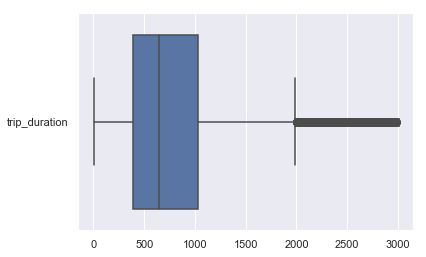

In [23]:
dataf= dataf[dataf.trip_duration < 3000]

sns.boxplot(data=dataf[["trip_duration"]], orient="h")



Even though, data above 2000 seconds could be still treated as outliers, 3000 seconds does appear to be a safe choice as an upper bound.

Plotting the distribution of trip duration.

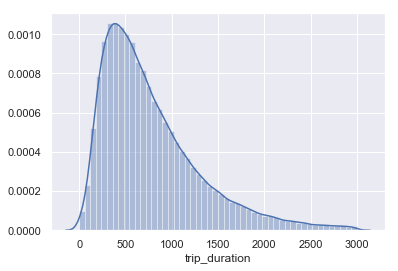

In [24]:
fig = sns.distplot(dataf["trip_duration"], norm_hist=True) 

We can plot to see how passenger count relates to trip duration. 

**Applying Reverse geocoding to coordinates and adding new columns indicating pick-up and drop-off districts:**

Creating a pair of coordinates and appending them in a list. 

In [25]:
p_locs = dataf[["pickup_latitude", "pickup_longitude"]].values

In [26]:
p_coords= []
for i in p_locs:
    p_coords.append(tuple(i))

In [27]:
p_adress = rg.search(p_coords)

Loading formatted geocoded file...


In [28]:
p_dist = []
for i in p_adress:
    p_dist.append(i["name"])

In [29]:
p_dist 

['Manhattan',
 'Long Island City',
 'Weehawken',
 'Manhattan',
 'New York City',
 'Hoboken',
 'Manhattan',
 'Manhattan',
 'New York City',
 'Long Island City',
 'Manhattan',
 'New York City',
 'Manhattan',
 'Manhattan',
 'Long Island City',
 'Manhattan',
 'Manhattan',
 'New York City',
 'New York City',
 'Manhattan',
 'Manhattan',
 'Weehawken',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'New York City',
 'Weehawken',
 'Weehawken',
 'Manhattan',
 'Weehawken',
 'New York City',
 'Guttenberg',
 'Jamaica',
 'New York City',
 'New York City',
 'Manhattan',
 'Edgewater',
 'New York City',
 'Weehawken',
 'Weehawken',
 'Manhattan',
 'Manhattan',
 'Weehawken',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'New York City',
 'New York City',
 'Brooklyn',
 'Manhattan',
 'Weehawken',
 'Manhattan',
 'Manhattan',
 'Hoboken',
 'New York City',
 'Weehawken',
 'New York City',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'New York City',
 'Long Island City',
 'Weehawken',
 'New York City',
 'New York City',


Creating a new column named pickup_district based on the results we found with reverse geocoding.

In [30]:
dataf["pickup_district"]= p_dist

Creating a pair of coordinates of the dropoff area and appending them in another list. 

In [31]:
d_locs=dataf[["dropoff_latitude","dropoff_longitude"]].values

In [32]:
d_coords=[]
for i in d_locs:
    d_coords.append(tuple(i))

In [33]:
d_adress = rg.search(d_coords)

In [34]:
d_dist= []
for i in d_adress:
    d_dist.append(i["name"])

In [35]:
d_dist

['Manhattan',
 'Manhattan',
 'Manhattan',
 'Long Island City',
 'New York City',
 'New York City',
 'Weehawken',
 'Manhattan',
 'New York City',
 'East New York',
 'Long Island City',
 'Borough of Queens',
 'New York City',
 'Guttenberg',
 'New York City',
 'Long Island City',
 'New York City',
 'New York City',
 'The Bronx',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'New York City',
 'Edgewater',
 'New York City',
 'Weehawken',
 'New York City',
 'Long Island City',
 'New York City',
 'Manhattan',
 'Coney Island',
 'New York City',
 'Long Island City',
 'New York City',
 'Inwood',
 'New York City',
 'New York City',
 'Long Island City',
 'Long Island City',
 'New York City',
 'Manhattan',
 'Long Island City',
 'Manhattan',
 'Guttenberg',
 'Long Island City',
 'New York City',
 'Brooklyn',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'New York City',
 'Weehawken',
 'Long Island City',
 'New York City',
 'New York City',
 'Long Island City',
 'Manhattan',
 'Ma

Creating a new column named dropoff_district on the dataframe. 

In [36]:
dataf["dropoff_district"]=d_dist

In [37]:
dataf.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_district,dropoff_district
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Manhattan,Manhattan
1,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,Long Island City,Manhattan
2,id3361153,1,2016-03-11 07:11:23,2016-03-11 07:20:09,1,-73.994560,40.750526,-73.978500,40.756191,N,526,Weehawken,Manhattan
3,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,Manhattan,Long Island City
4,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,New York City,New York City


Extracting top 5 districts where passengers where picked up and dropped off.

In [38]:
dataf.pickup_district.value_counts()[:5]

Manhattan           45003
New York City       34349
Long Island City    17651
Weehawken           11246
The Bronx            2578
Name: pickup_district, dtype: int64

In [39]:
dataf.dropoff_district.value_counts()[:5]

Manhattan           44108
New York City       30773
Long Island City    19749
Weehawken           10527
Brooklyn             1959
Name: dropoff_district, dtype: int64

**Calculating geodesic distance between pickup and dropoff coordinates:**

In [40]:
distance=[]
for index, row in dataf.iterrows():
    start = (row["pickup_latitude"], row["pickup_longitude"])
    stop = (row["dropoff_latitude"], row["dropoff_longitude"])
    distance.append(geodesic(start,stop).miles)

Appending the list of distances into the dataframe as a new column.

Note: Distance unit is taken as miles.

In [41]:
dataf["distance"]=distance

In [42]:
dataf.head(20)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_district,dropoff_district,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Manhattan,Manhattan,0.933406
1,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,Long Island City,Manhattan,3.178194
2,id3361153,1,2016-03-11 07:11:23,2016-03-11 07:20:09,1,-73.994560,40.750526,-73.978500,40.756191,N,526,Weehawken,Manhattan,0.928961
3,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,Manhattan,Long Island City,1.228003
4,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,New York City,New York City,1.562103
5,id0970832,1,2016-03-12 20:39:39,2016-03-12 21:05:40,1,-74.008247,40.747353,-73.979446,40.718750,N,1561,Hoboken,New York City,2.486098
6,id2049424,2,2016-03-02 20:15:07,2016-03-02 20:37:43,1,-73.963890,40.773651,-74.005112,40.751492,N,1356,Manhattan,Weehawken,2.648687
7,id0038484,2,2016-03-09 13:41:11,2016-03-09 13:53:27,2,-73.972855,40.764400,-73.971809,40.757889,N,736,Manhattan,Manhattan,0.452659
8,id3092788,2,2016-03-03 22:01:32,2016-03-03 22:17:44,2,-73.984772,40.710571,-73.989410,40.730148,N,972,New York City,New York City,1.372636
9,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,Long Island City,East New York,1.809375


**Categorizing the time of the day:**

Creating an empty list to assign time of the day as 5 divisions based on time, then appending the list to the corresponding rows as new column.

In [43]:

time_of_day= []
for index, row in dataf.iterrows():
    if row["pickup_datetime"].hour >= 7 and row["pickup_datetime"].hour < 9:
        time_of_day.append("rush_hour_morning")
    elif row["pickup_datetime"].hour >= 9 and row["pickup_datetime"].hour < 16:
        time_of_day.append("afternoon")
    elif row["pickup_datetime"].hour >= 16 and row["pickup_datetime"].hour < 18:
        time_of_day.append("rush_hour_evening")
    elif row["pickup_datetime"].hour >= 18 and row["pickup_datetime"].hour < 23:
        time_of_day.append("evening")
    elif row["pickup_datetime"].hour >= 23 or row["pickup_datetime"].hour < 7:
        time_of_day.append("late_night")

dataf["time_of_day"] = time_of_day    


In [44]:
dataf.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_district,dropoff_district,distance,time_of_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Manhattan,Manhattan,0.933406,rush_hour_evening
1,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,Long Island City,Manhattan,3.178194,evening
2,id3361153,1,2016-03-11 07:11:23,2016-03-11 07:20:09,1,-73.994560,40.750526,-73.978500,40.756191,N,526,Weehawken,Manhattan,0.928961,rush_hour_morning
3,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,Manhattan,Long Island City,1.228003,afternoon
4,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,New York City,New York City,1.562103,afternoon


Comparing occurences of each daytime.

In [45]:
dataf.time_of_day.value_counts()

afternoon            39099
evening              34959
late_night           21316
rush_hour_evening    11216
rush_hour_morning     9952
Name: time_of_day, dtype: int64

Calculating the average distance traveled on each daytime. 

In [46]:
avr_dist_rhm = dataf[dataf.time_of_day == "rush_hour_morning"].distance.mean()
avr_dist_aftern = dataf[dataf.time_of_day == "afternoon"].distance.mean()
avr_dist_rhe = dataf[dataf.time_of_day == "rush_hour_evening"].distance.mean()
avr_dist_eve = dataf[dataf.time_of_day == "evening"].distance.mean()
avr_dist_laten = dataf[dataf.time_of_day == "late_night"].distance.mean()

Based on average distances, plotting a bar graph for the corresponding daytimes.

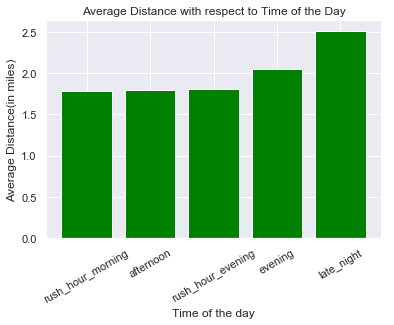

In [47]:
x =["rush_hour_morning","afternoon", "rush_hour_evening","evening","late_night"]
average_distance = [avr_dist_rhm,avr_dist_aftern, avr_dist_rhe, avr_dist_eve, avr_dist_laten]
x_pos = [i for i, _ in enumerate(x)]  
plt.bar(x_pos, average_distance, color='green')

plt.xticks(rotation=30)

plt.xlabel("Time of the day")
plt.ylabel("Average Distance(in miles)")
plt.title("Average Distance with respect to Time of the Day")
plt.xticks(x_pos, x)
plt.show()


On average, on latenights the distance travelled was the most, followed by evenings and the average distance taken on rush hour mornings,afternoons and rush hour evenings are relatively close to eachother.

In order to investigate how daytimes and trip durations are related, mean values of trip durations for each section of daytimes are calculated.

In [48]:
avr_tdur_rhm = dataf[dataf.time_of_day == "rush_hour_morning"].trip_duration.mean()
avr_tdur_aftern = dataf[dataf.time_of_day == "afternoon"].trip_duration.mean()
avr_tdur_rhe = dataf[dataf.time_of_day == "rush_hour_evening"].trip_duration.mean()
avr_tdur_eve = dataf[dataf.time_of_day == "evening"].trip_duration.mean()
avr_tdur_laten = dataf[dataf.time_of_day == "late_night"].trip_duration.mean()

Using a bar graph to illustrate the means of each daytimes.

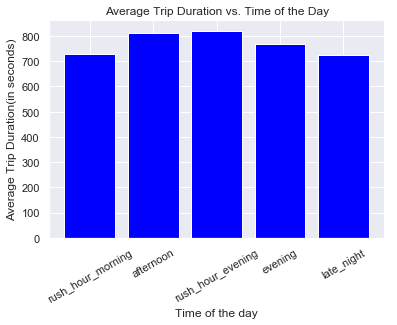

In [49]:
ax = ["rush_hour_morning","afternoon", "rush_hour_evening","evening","late_night"]
avr_duration = [avr_tdur_rhm, avr_tdur_aftern, avr_tdur_rhe, avr_tdur_eve, avr_tdur_laten]
x_pos = [i for i, _ in enumerate(ax)]  
plt.bar(x_pos, avr_duration, color='blue')

plt.xticks(rotation = 30)
plt.xlabel("Time of the day")
plt.ylabel("Average Trip Duration(in seconds)")
plt.title("Average Trip Duration vs. Time of the Day")
plt.xticks(x_pos, ax)
plt.show()




Overall, regardless of time of the day, the mean value of each category lies between 700-800 seconds. 

### Hypothesis Testing

##### 1- Does passenger size affect the distance?

Null hypothesis: Passenger group size has no effect on the distance. 

Starting off with 6 groups of passenger size to evaluate whether having six groups or two groups classified as single and multiple passengers would be a better approach. 

Starting by the means of distance traveled for each passenger count. 

In [50]:
avr_dist_1 = dataf[dataf.passenger_count == 1]["distance"].mean()
avr_dist_2 = dataf[dataf.passenger_count == 2]["distance"].mean()
avr_dist_3 = dataf[dataf.passenger_count == 3]["distance"].mean()
avr_dist_4 = dataf[dataf.passenger_count == 4]["distance"].mean()
avr_dist_5 = dataf[dataf.passenger_count == 5]["distance"].mean()
avr_dist_6 = dataf[dataf.passenger_count == 6]["distance"].mean()

Producing a bar graph indicating mean distances corresponding to each group of passengers.

Text(0, 0.5, 'Average distance ( in miles)')

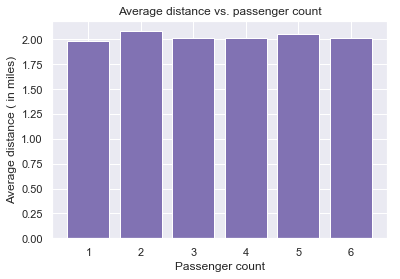

In [51]:
x = ["1", "2","3", "4","5","6"]
avr_d= [avr_dist_1,avr_dist_2,avr_dist_3,avr_dist_4,avr_dist_5,avr_dist_6]
plt.bar(x, avr_d, 
    color='m',
    label='x')
plt.title("Average distance vs. passenger count")
plt.xlabel("Passenger count")
plt.ylabel("Average distance ( in miles)")

Acoording to this graph, the means of each group appear to be around 2.0 miles with a difference of significance of about 0.1-0.2. Therefore, instead of proceeding with 6 different groups and apply hypothesis test, it seems more practical to proceed with 2 distinct groups with single and mutiple passengers.

After such separation in the passenger group size, we can investigate whether passenger amount had any substantial correlation with the distance traveled in taxis. 

In [52]:
test_variable = "distance"
one_passenger = dataf[dataf["passenger_count"] == 1][test_variable] 
multiple_passenger = dataf[dataf["passenger_count"] > 1][test_variable]

Comparing the mean of distance traveled within the two groups:

In [53]:
print("Mean of distance traveled (in miles) in taxis with one passenger: {:.2f}".format(one_passenger.mean()))

Mean of distance traveled (in miles) in taxis with one passenger: 1.99


In [54]:
print("Mean of distance traveled(in miles) in taxis with multiple passengers: {:.2f}".format(multiple_passenger.mean()))

Mean of distance traveled(in miles) in taxis with multiple passengers: 2.05


The mean values of the two groups are still close. 

Plotting histograms to show the distance distributions on the two groups based on passenger count.

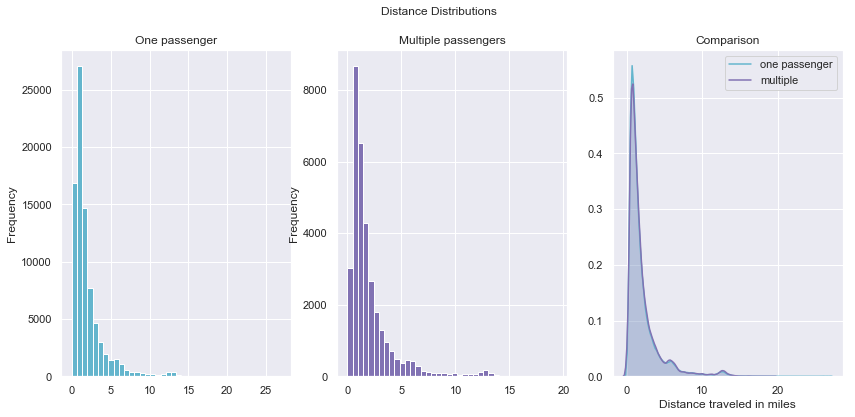

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(14,6))
        
one_passenger.plot(kind="hist", ax=ax[0], bins=40, color="c")
ax[0].set_title("One passenger")

multiple_passenger.plot(kind="hist", ax=ax[1], bins=40,  color="m")
ax[1].set_title("Multiple passengers")


plt.xlabel("Distance traveled in miles")


sns.kdeplot(one_passenger, shade=True, label="one passenger", ax=ax[2], color="c")
sns.kdeplot(multiple_passenger, shade=True, label="multiple", ax=ax[2], color="m")
ax[2].set_title("Comparison")


plt.suptitle("Distance Distributions")
plt.show()

From the comparison graph, initial observation may suggest that regardless of passenger size, both groups tend to show similar patterns on distance distribution. However, first and second graphs are scaled differently and any conclusions drawn just from these graphs would be misleading and not sufficient to conclude on the hypothesis. 

For further investigation with t-test will be implemented. 

##### T-Test on investigating the effect of passenger size on distance

In [56]:
stats.ttest_ind(one_passenger, multiple_passenger, equal_var=False) 

Ttest_indResult(statistic=-4.847953732809688, pvalue=1.2505288962022252e-06)

Given that we set the threshold value of p as 0.05, the result obtained from t-test ( 1.2505288962022252e-06) is significantly lower than the threshold value. The lower the p-value from the threshold, the more likely it is that the null hypothesis that "Passenger group size has no effect on the distance" can be rejected in favor of the alternative hypothesis when we group passsenger count into two: single and multiple.  
Thus, the outcome is in favor of the alternative hypothesis: "Passenger group size has an effect on the distance."


##### 2- Do trip distances increase on weekends? 

Null hypothesis: The day of the week has no effect on the distance. 

For this hypothesis, grouping the days as weekdays and weekends is preferred. 


Iterating through datetime objects in each row to find whether it is a weekday or weekend. 

In [57]:
week = []
for index, row in dataf.iterrows():
    if row["pickup_datetime"].weekday() < 5:
        week.append("weekday")
    else:
        week.append("weekend")
   

Adding a column named "time_of_week" to the dataframe. 

In [58]:
dataf["time_of_week"] = week

In [59]:
dataf.time_of_week.value_counts()

weekday    82211
weekend    34331
Name: time_of_week, dtype: int64

For a general look, "average distance vs. time of the week" graph is plotted. 

Text(0, 0.5, 'Average distance ( in miles)')

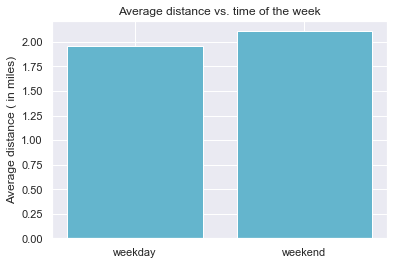

In [60]:
weekday_avrd = dataf[dataf["time_of_week"] == "weekday"]["distance"].mean()
weekend_avrd = dataf[dataf["time_of_week"] == "weekend"]["distance"].mean()
 
x = ["weekday","weekend"]
avr_d= [weekday_avrd,weekend_avrd]
plt.bar(x, avr_d, 
    color='c',
    label='x')
plt.title("Average distance vs. time of the week")

plt.ylabel("Average distance ( in miles)")


To get a better idea, we can also check how distance is distributed between weekdays and weekends.

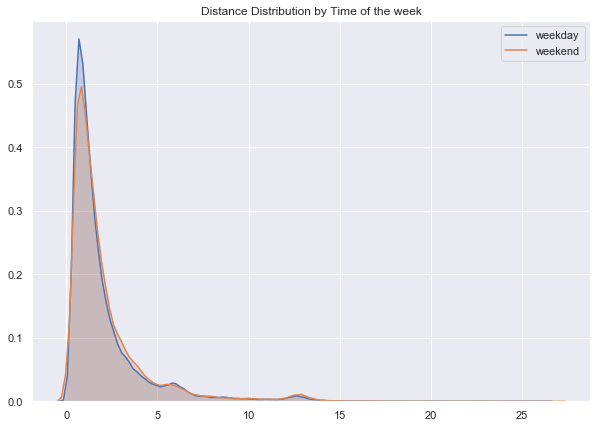

In [61]:
weekday = dataf[dataf["time_of_week"] == "weekday"]["distance"]
weekend = dataf[dataf["time_of_week"] == "weekend"]["distance"]

fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.kdeplot(weekday, shade=True, ax=ax, label="weekday")
sns.kdeplot(weekend, shade=True, ax=ax, label="weekend")
plt.title("Distance Distribution by Time of the week")
plt.show()


##### T-Test on investigating whether the day of the week has an effect on distance

In [62]:
stats.ttest_ind(weekday, weekend, equal_var=False) 

Ttest_indResult(statistic=-10.213015340565912, pvalue=1.813865212404701e-24)

P-value is very low compared to the threshold value of 0.05. This suggests that null hypothesis can be rejected in favor of the alternative hypothesis when we group days of the week into weekdays and weekends. Thus, the outcome is in favor of the alternative hypothesis: "The day of the week has an effect on distance traveled."